# Strategy analysis example

Debugging a strategy can be time-consuming. Freqtrade offers helper functions to visualize raw data.
The following assumes you work with SampleStrategy, data for 5m timeframe from Binance and have downloaded them into the data directory in the default location.

In [1]:
#
# Initialization
#
import os
import sys

import ipynbname
from pathlib import Path

# Set notebook's src module path. Note that you may have to update your IDE's project settings to do the same for the
#  local library imports to work the same

MODULE_PATH = ipynbname.path().parent.parent.parent.parent
sys.path.append(str(MODULE_PATH))

# Keep paths consistent throughout notebook
os.chdir(MODULE_PATH)

# This should always be `./src`
print(f"Current working directory [{os.getcwd()}]")

# Place all local artifacts in a disposable, git-ignored directory
local_artifact_dir = Path(os.getcwd()).parent / "out"
local_artifact_dir.mkdir(parents=True, exist_ok=True)

# Autoreload imports at the beginning of cell execution.
#  https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Current working directory [/Users/jbeckman/projects/capia/src]


In [2]:
#
# Setup utils
#

from utils.logger_util import LoggerUtil
from utils.utils import Utils
from utils import config

LOGGER = LoggerUtil(config.MODEL_ID, local_artifact_dir / "logs")
UTILS = Utils(LOGGER)

UTILS.describe_env()

2021-05-09 21:41:18.376362 Background logger started
2021-05-09 21:41:18.376938 The model id is [giia-0.5.8]
2021-05-09 21:41:18.377030 The MXNet version is [1.7.0]
2021-05-09 21:41:18.377102 The GluonTS version is [0.7.1.dev3+gecb903f]
2021-05-09 21:41:18.377299 The GPU count is [0]


In [3]:
from freqtrade.configuration import Configuration

from utils import config

# First prime the user_data_dir key. This will take priority when merged with config.json
freqtrade_config = Configuration({"user_data_dir": config.FREQTRADE_USER_DATA_DIR})
freqtrade_config = freqtrade_config.load_from_files([str(config.FREQTRADE_USER_DATA_DIR / "config.json")])
freqtrade_config["user_data_dir"] = config.FREQTRADE_USER_DATA_DIR

In [4]:
# Load data using values set above
from freqtrade.data.history import load_pair_history

candles = load_pair_history(
    datadir=config.FREQTRADE_USER_DATA_DIR / "data" / "binance",
    timeframe=freqtrade_config["timeframe"],
    pair=config.CRYPTO_PAIR)

# Confirm success
print("Loaded " + str(len(candles)) + f" rows of data for {config.CRYPTO_PAIR} from {config.FREQTRADE_USER_DATA_DIR}")
candles.head()

Loaded 1960455 rows of data for ETH/USDT from freqtrade/user_data


,date,open,high,low,close,volume
0,2017-08-17 04:00:00+00:00,301.13,301.13,301.13,301.13,0.42643
1,2017-08-17 04:01:00+00:00,301.13,301.13,301.13,301.13,2.75787
2,2017-08-17 04:02:00+00:00,300.00,300.00,300.00,300.00,0.09930
3,2017-08-17 04:03:00+00:00,300.00,300.00,300.00,300.00,0.31389
4,2017-08-17 04:04:00+00:00,301.13,301.13,301.13,301.13,0.23202


## Load and run strategy
* Rerun each time the strategy file is changed

In [8]:
import matplotlib.pyplot as plt

# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver

import data_processing.marshal_features as mf

# candles_df = candles.tail(50).copy()
candles_df = candles.copy()
strategy = StrategyResolver.load_strategy(freqtrade_config)

# Generate buy/sell signals using strategy
df = strategy.analyze_ticker(candles_df, {'pair': config.CRYPTO_PAIR})

# import jenkspy
# NATURAL_VOLUME_BREAKS = jenkspy.jenks_breaks(df["volume"], nb_class=10)
# print(NATURAL_VOLUME_BREAKS)

Number of momentum_indicator: 9
Number of overlap_studies: 1
Number of pattern_recognition: 2
Number of volume_bin: 1


--------
count    185175.000000
mean        825.665843
std         954.624107
min           0.000000
25%         319.438940
50%         532.590560
75%         950.981675
max       23620.741110
Name: volume, dtype: float64
[0.0, 604.22808, 1263.66949, 2312.48193, 4048.12917, 7249.01953, 23620.74111]
--------
                       open    high     low   close      volume        mfi  \
date                                                                         
2021-01-01 00:00:00  736.42  737.09  735.94  737.02   647.71994  67.016654   
2021-01-01 00:01:00  737.12  739.00  737.06  738.74  1122.95415  68.532987   
2021-01-01 00:02:00  738.78  738.81  737.35  737.82   418.49987  61.247763   
2021-01-01 00:03:00  737.74  738.20  737.28  737.43   305.98424  54.867077   
2021-01-01 00:04:00  737.38  737.80  736.80  736.89   350.36312  49.206618   

                          roc        adx        rsi      slowd      slowk  \
date                                                               

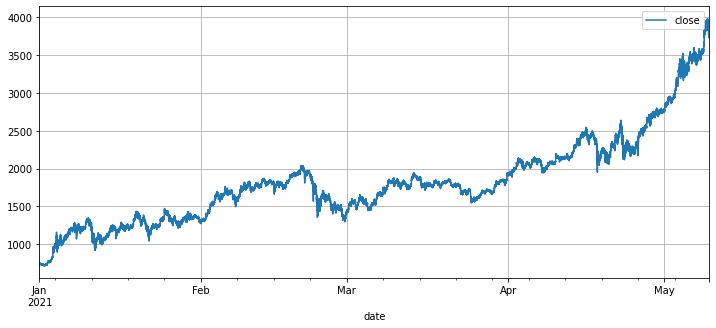

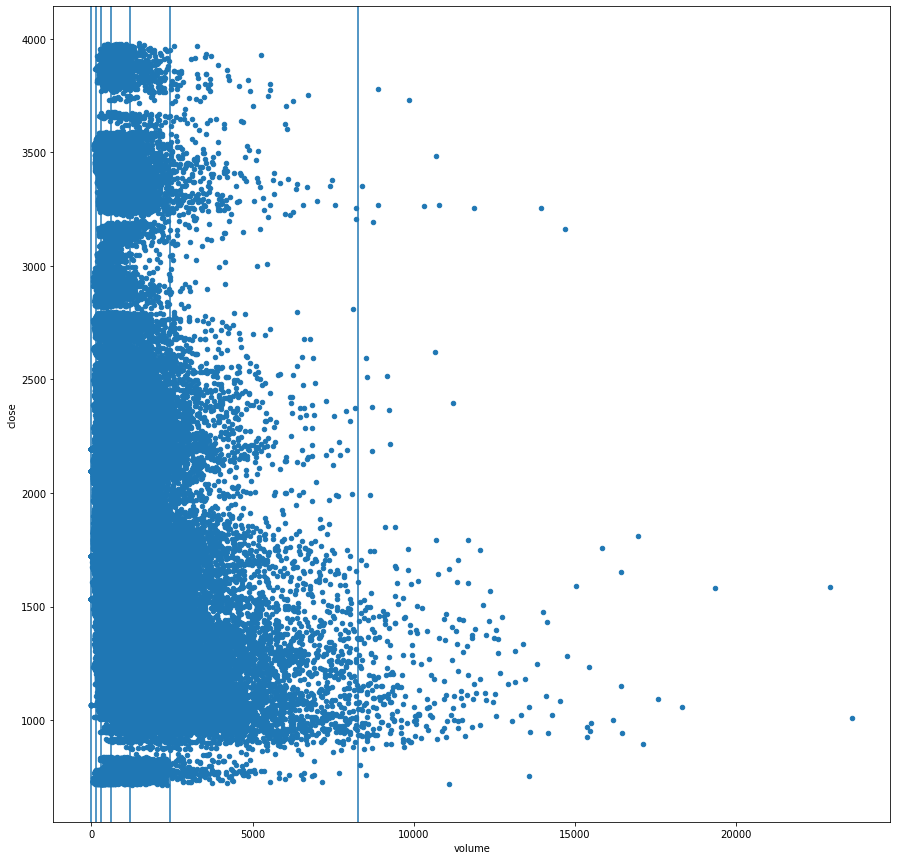

In [9]:
print("--------")
print(df["volume"].describe())
import jenkspy
NATURAL_VOLUME_BREAKS = jenkspy.jenks_breaks(df["volume"], nb_class=6)
print(NATURAL_VOLUME_BREAKS)
print("--------")
print(df.head(5))
print("--------")

# df_plot = df.drop(['sell', 'buy', "volume", "open", "high", "low", "close", "hma"], axis=1)
df_plot2 = df[["close"]]
ax = df_plot2.plot(figsize=(12, 5))
plt.grid()
plt.legend(df_plot2.columns)
plt.show()

ax = df.plot(kind='scatter', x="volume", y='close', figsize=(15, 15))
[plt.axvline(x) for x in mf.NATURAL_VOLUME_BREAKS]

# # This takes some time to generate
# from pandas.plotting import scatter_matrix
# scatter_matrix(df_plot, alpha=0.2, figsize=(12, 12), diagonal='kde')

# df_plot[-499:].plot(figsize=(12, 5), linewidth=2)
# plt.grid()
# plt.legend(df_plot.columns)
# plt.show()

# ax = df_plot.plot(kind='scatter', x='volume_bin', y='pattern_detected', figsize=(15, 15))
# ax = df_plot.plot(kind='scatter', x='pattern_count', y='pattern_detected', figsize=(15, 15))
# ax = df_plot.plot(kind='scatter', x='volume', y='pattern_detected', figsize=(15, 15))

### Display the trade details

* Note that using `data.head()` would also work, however most indicators have some "startup" data at the top of the dataframe.
* Some possible problems
    * Columns with NaN values at the end of the dataframe
    * Columns used in `crossed*()` functions with completely different units
* Comparison with full backtest
    * having 200 buy signals as output for one pair from `analyze_ticker()` does not necessarily mean that 200 trades will be made during backtesting.
    * Assuming you use only one condition such as, `df['rsi'] < 30` as buy condition, this will generate multiple "buy" signals for each pair in sequence (until rsi returns > 29). The bot will only buy on the first of these signals (and also only if a trade-slot ("max_open_trades") is still available), or on one of the middle signals, as soon as a "slot" becomes available.  


In [ ]:
# Report results
print(f"Generated {df['buy'].sum()} buy signals")
data = df.set_index('date', drop=False)
data.tail()

## Load existing objects into a Jupyter notebook

The following cells assume that you have already generated data using the cli.  
They will allow you to drill deeper into your results, and perform analysis which otherwise would make the output very difficult to digest due to information overload.

### Load backtest results to pandas dataframe

Analyze a trades dataframe (also used below for plotting)

In [ ]:
from freqtrade.data.btanalysis import load_backtest_data, load_backtest_stats

# if backtest_dir points to a directory, it'll automatically load the last backtest file.
backtest_dir = config["user_data_dir"] / "backtest_results"
# backtest_dir can also point to a specific file 
# backtest_dir = config["user_data_dir"] / "backtest_results/backtest-result-2020-07-01_20-04-22.json"

In [ ]:
# You can get the full backtest statistics by using the following command.
# This contains all information used to generate the backtest result.
stats = load_backtest_stats(backtest_dir)

strategy = 'SampleStrategy'
# All statistics are available per strategy, so if `--strategy-list` was used during backtest, this will be reflected here as well.
# Example usages:
print(stats['strategy'][strategy]['results_per_pair'])
# Get pairlist used for this backtest
print(stats['strategy'][strategy]['pairlist'])
# Get market change (average change of all pairs from start to end of the backtest period)
print(stats['strategy'][strategy]['market_change'])
# Maximum drawdown ()
print(stats['strategy'][strategy]['max_drawdown'])
# Maximum drawdown start and end
print(stats['strategy'][strategy]['drawdown_start'])
print(stats['strategy'][strategy]['drawdown_end'])

# Get strategy comparison (only relevant if multiple strategies were compared)
print(stats['strategy_comparison'])


In [ ]:
# Load backtested trades as dataframe
trades = load_backtest_data(backtest_dir)

# Show value-counts per pair
trades.groupby("pair")["sell_reason"].value_counts()

### Load live trading results into a pandas dataframe

In case you did already some trading and want to analyze your performance

In [ ]:
from freqtrade.data.btanalysis import load_trades_from_db

# Fetch trades from database
trades = load_trades_from_db("sqlite:///tradesv3.sqlite")

# Display results
trades.groupby("pair")["sell_reason"].value_counts()

## Analyze the loaded trades for trade parallelism
This can be useful to find the best `max_open_trades` parameter, when used with backtesting in conjunction with `--disable-max-market-positions`.

`analyze_trade_parallelism()` returns a timeseries dataframe with an "open_trades" column, specifying the number of open trades for each candle.

In [ ]:
from freqtrade.data.btanalysis import analyze_trade_parallelism

# Analyze the above
parallel_trades = analyze_trade_parallelism(trades, '5m')

parallel_trades.plot()

## Plot results

Freqtrade offers interactive plotting capabilities based on plotly.

In [ ]:
from freqtrade.plot.plotting import generate_candlestick_graph

# Limit graph period to keep plotly quick and reactive

# Filter trades to one pair
trades_red = trades.loc[trades['pair'] == pair]

data_red = data['2019-06-01':'2019-06-10']
# Generate candlestick graph
graph = generate_candlestick_graph(pair=pair,
                                   data=data_red,
                                   trades=trades_red,
                                   indicators1=['sma20', 'ema50', 'ema55'],
                                   indicators2=['rsi', 'macd', 'macdsignal', 'macdhist']
                                   )




In [ ]:
# Show graph inline
# graph.show()

# Render graph in a seperate window
graph.show(renderer="browser")


Feel free to submit an issue or Pull Request enhancing this document if you would like to share ideas on how to best analyze the data.